In [17]:
import yfinance as yf
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

##### Step 1: Data Download

In [18]:
apple = yf.download("AAPL", start="2015-01-01", end="2025-11-25", auto_adjust=False)
toyota = yf.download("7203.T", start="2015-01-01", end="2025-11-25", auto_adjust=False)
display(apple.head(), toyota.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2015-01-02,24.237553,27.332500,27.860001,26.837500,27.847500,212818400
2015-01-05,23.554737,26.562500,27.162500,26.352501,27.072500,257142000
2015-01-06,23.556961,26.565001,26.857500,26.157499,26.635000,263188400
2015-01-07,23.887280,26.937500,27.049999,26.674999,26.799999,160423600
2015-01-08,24.805086,27.972500,28.037500,27.174999,27.307501,237458000


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,7203.T,7203.T,7203.T,7203.T,7203.T,7203.T
Date,,,,,,
2015-01-05,1075.321411,1501.400024,1515.000000,1483.199951,1513.000000,47576500
2015-01-06,1045.670532,1460.000000,1478.199951,1460.000000,1464.400024,61939500
2015-01-07,1060.997192,1481.400024,1497.000000,1451.000000,1451.199951,57327000
2015-01-08,1082.054199,1510.800049,1511.199951,1499.000000,1500.000000,50272500
2015-01-09,1089.932495,1521.800049,1533.199951,1512.199951,1526.000000,52127000


##### Step 2: Feature Engineering

In [19]:
import numpy as np

#1 Extract close price and force business day frequency
apple_ts = apple["Close"].asfreq("B")
toyota_ts = toyota["Close"].asfreq("B")

#2 Forward fill missing values (Holidays and weekends)
apple_ts = apple_ts.ffill()
toyota_ts = toyota_ts.ffill()

##### Step 3: Training/Validation/Testing Splits

In [20]:
# Apple data
apple_ts = apple_ts.dropna()

n = len(apple_ts)
train_size = int(n * 0.70)
val_size   = int(n * 0.15)

apple_train = apple_ts.iloc[:train_size]
apple_val   = apple_ts.iloc[train_size : train_size + val_size]
apple_test  = apple_ts.iloc[train_size + val_size :]

print("APPLE SPLIT:")
print("Train:", apple_train.shape)
print("Validation:", apple_val.shape)
print("Test:", apple_test.shape)

# Toyota data
toyota_ts = toyota_ts.dropna()

n2 = len(toyota_ts)
train_size2 = int(n2 * 0.70)
val_size2   = int(n2 * 0.15)

toyota_train = toyota_ts.iloc[:train_size2]
toyota_val   = toyota_ts.iloc[train_size2 : train_size2 + val_size2]
toyota_test  = toyota_ts.iloc[train_size2 + val_size2 :]

apple_full_train = pd.concat([apple_train, apple_val])
toyota_full_train = pd.concat([toyota_train, toyota_val])

print("\nTOYOTA SPLIT:")
print("Train:", toyota_train.shape)
print("Validation:", toyota_val.shape)
print("Test:", toyota_test.shape)

APPLE SPLIT:
Train: (1989, 1)
Validation: (426, 1)
Test: (427, 1)

TOYOTA SPLIT:
Train: (1987, 1)
Validation: (426, 1)
Test: (427, 1)


##### Step 4: ARIMA Model Creation

In [21]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_arima(train, val, p, d, q):
    # Convert to pandas Series no matter what the input is
    train = pd.Series(np.array(train).flatten(), dtype=float)
    val   = pd.Series(np.array(val).flatten(), dtype=float)

    history = train.copy()
    predictions = []

    for t in range(len(val)):
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit()

        yhat = model_fit.forecast(steps=1).iloc[0]
        predictions.append(yhat)

        # Append new value as Series so concat works
        new_value = pd.Series([val.iloc[t]], dtype=float)
        history = pd.concat([history, new_value], ignore_index=True)

    predictions = np.array(predictions)

    rmse = np.sqrt(mean_squared_error(val, predictions))
    mae  = mean_absolute_error(val, predictions)

    return predictions, rmse, mae, model_fit


##### Step 5: Evaluation Metrics

In [23]:
# Testing model with ARIMA(1,1,1)
# p = autoregressive term (AR), looks back p many days to predict next day
# d = differencing term, number of times data is differenced to remove trends
# q = moving average (MA), captures patterns in the error; leftover error from previous predictions
p, d, q = 1,1,1

#Market Errors (In terms of currency USD/yen)
apple_val_pred, apple_rmse, apple_mae, apple_model = evaluate_arima(apple_train, apple_val, p, d, q)

print("APPLE ARIMA(1,1,1)")
print("RMSE:", apple_rmse)
print("MAE:", apple_mae)

toyota_val_pred, toyota_rmse, toyota_mae, toyota_model = evaluate_arima(toyota_train, toyota_val, p, d, q)

print("\nTOYOTA ARIMA(1,1,1)")
print("RMSE:", toyota_rmse)
print("MAE:", toyota_mae)

#Percentage Errors

#For Apple
apple_actual_avg = apple_val.mean().iloc[0] 
apple_rmse_pct = (apple_rmse / apple_actual_avg) * 100
apple_mae_pct = (apple_mae / apple_actual_avg) * 100

print("\nAPPLE Vaidation Percentage Errors:")
print(f"RMSE Percentage: {apple_rmse_pct:.3f}%")
print(f"MAE Percentage:  {apple_mae_pct:.3f}%")


# For Toyota
toyota_actual_avg = toyota_val.mean().iloc[0]
toyota_rmse_pct = (toyota_rmse / toyota_actual_avg) * 100
toyota_mae_pct = (toyota_mae / toyota_actual_avg) * 100

print("\nTOYOTA Validation Percentage Errors:")
print(f"RMSE Percentage: {toyota_rmse_pct:.3f}%")
print(f"MAE Percentage:  {toyota_mae_pct:.3f}%")

APPLE ARIMA(1,1,1)
RMSE: 2.5181523108927744
MAE: 1.8552810693210557

TOYOTA ARIMA(1,1,1)
RMSE: 39.946975213517725
MAE: 27.202398287588757

APPLE Vaidation Percentage Errors:
RMSE Percentage: 1.497%
MAE Percentage:  1.103%

TOYOTA Validation Percentage Errors:
RMSE Percentage: 1.694%
MAE Percentage:  1.154%


##### Step 6: Plotting Prediction vs Actual

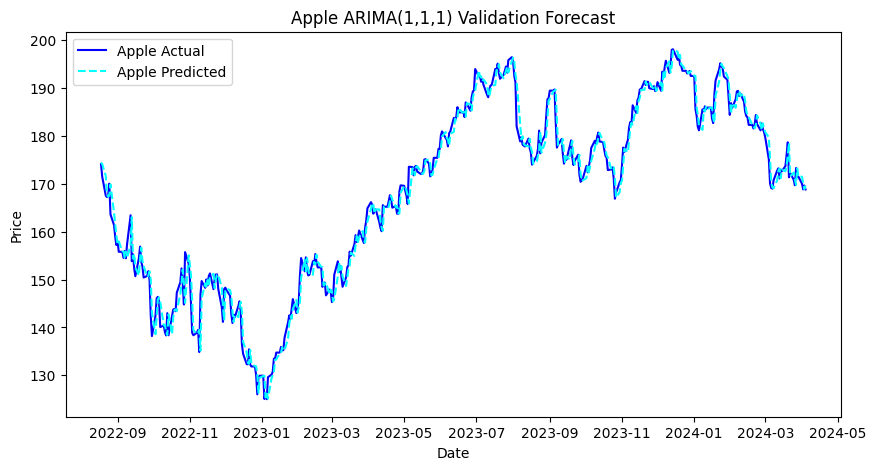

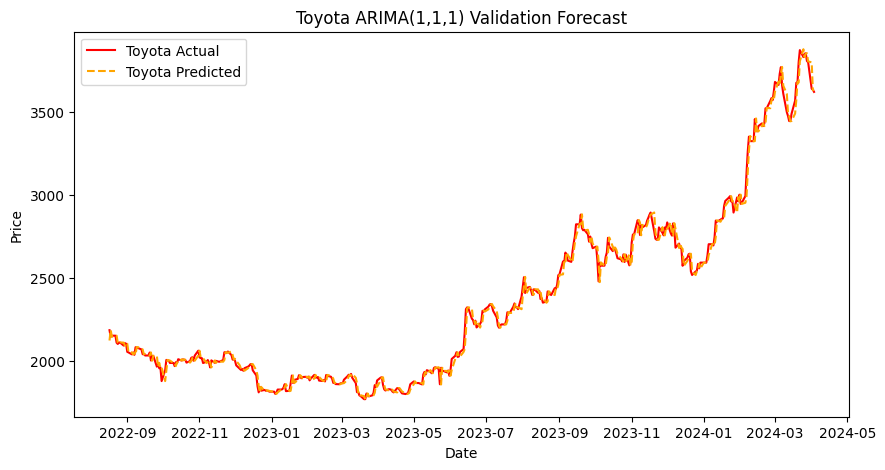

In [24]:
import matplotlib.pyplot as plt

# --- Apple plot ---
plt.figure(figsize=(10,5))
plt.plot(apple_val.index, apple_val, label='Apple Actual', color='blue')
plt.plot(apple_val.index, apple_val_pred, label='Apple Predicted', color='cyan', linestyle='--')
plt.title("Apple ARIMA(1,1,1) Validation Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# --- Toyota plot ---
plt.figure(figsize=(10,5))
plt.plot(toyota_val.index, toyota_val, label='Toyota Actual', color='red')
plt.plot(toyota_val.index, toyota_val_pred, label='Toyota Predicted', color='orange', linestyle='--')
plt.title("Toyota ARIMA(1,1,1) Validation Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


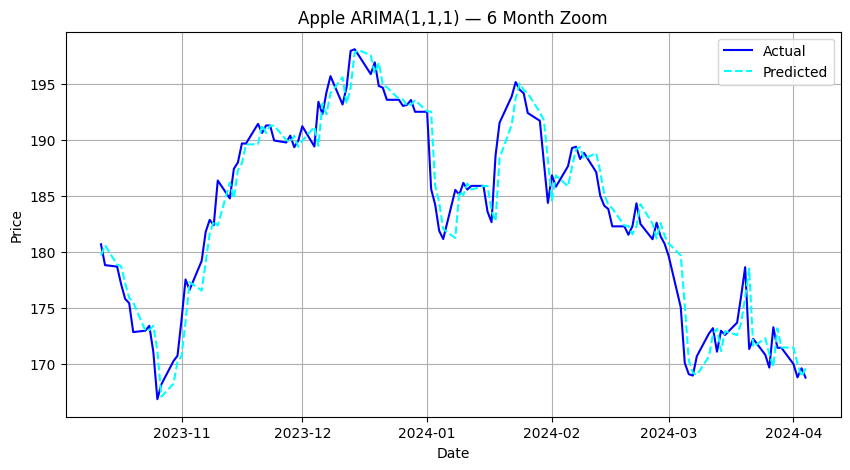

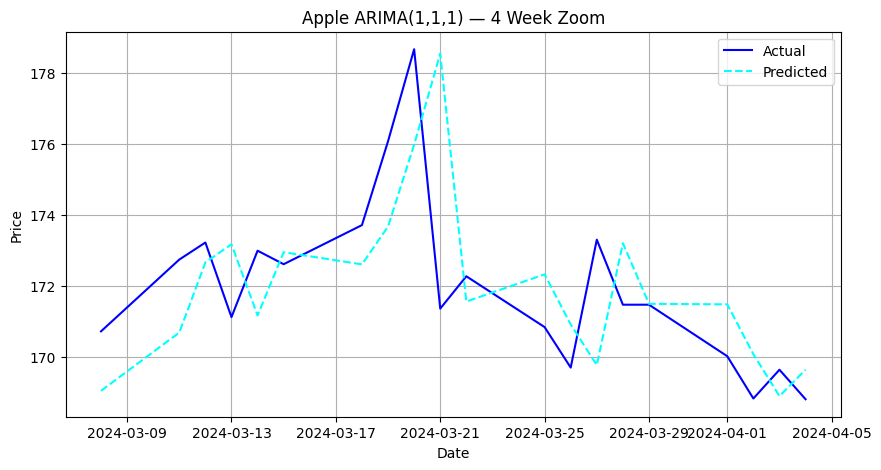

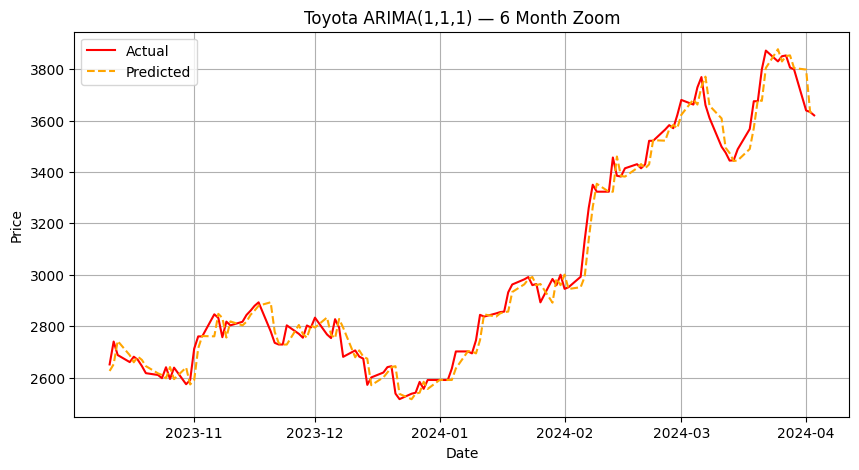

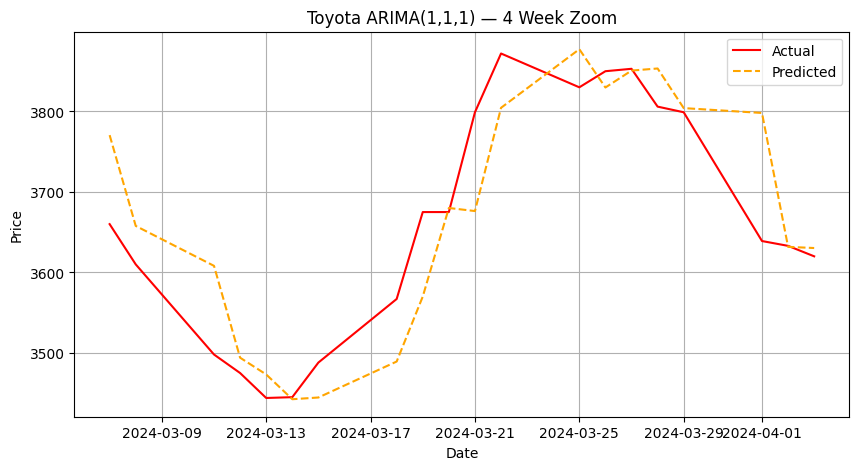

In [27]:
def plot_zoomed(actual, predicted, title, actual_color, pred_color, zoom_months=6, zoom_weeks=4):

    # Force 1D Series
    actual = pd.Series(np.array(actual).squeeze(), index=actual.index)
    predicted = pd.Series(np.array(predicted).squeeze(), index=predicted.index)

    # Combine into DataFrame
    df = pd.DataFrame({"Actual": actual, "Predicted": predicted})

    # --- 6 Month Zoom ---
    plt.figure(figsize=(10,5))
    zoom_6m = df.iloc[-(zoom_months * 21):]   # ~21 trading days per month
    plt.plot(zoom_6m.index, zoom_6m["Actual"], label="Actual", color=actual_color)
    plt.plot(zoom_6m.index, zoom_6m["Predicted"], label="Predicted", color=pred_color, linestyle="--")
    plt.title(f"{title} — 6 Month Zoom")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 4 Week Zoom ---
    plt.figure(figsize=(10,5))
    zoom_4w = df.iloc[-(zoom_weeks * 5):]     # ~5 trading days per week
    plt.plot(zoom_4w.index, zoom_4w["Actual"], label="Actual", color=actual_color)
    plt.plot(zoom_4w.index, zoom_4w["Predicted"], label="Predicted", color=pred_color, linestyle="--")
    plt.title(f"{title} — 4 Week Zoom")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Apple Zoomed
plot_zoomed(
    actual=apple_val,
    predicted=pd.Series(apple_val_pred, index=apple_val.index),
    title="Apple ARIMA(1,1,1)",
    actual_color="blue",
    pred_color="cyan"
)

# Toyota Zoomed
plot_zoomed(
    actual=toyota_val,
    predicted=pd.Series(toyota_val_pred, index=toyota_val.index),
    title="Toyota ARIMA(1,1,1)",
    actual_color="red",
    pred_color="orange"
)


#### Step 7: Comparing Validation and Testing 

In [28]:
# APPLE TEST EVALUATION
apple_test_pred, apple_test_rmse, apple_test_mae, _ = evaluate_arima(
    apple_full_train,
    apple_test,
    p=1, d=1, q=1
)

print("APPLE TEST RESULTS")
print("RMSE:", apple_test_rmse)
print("MAE:", apple_test_mae)


# TOYOTA TEST EVALUATION
toyota_test_pred, toyota_test_rmse, toyota_test_mae, _ = evaluate_arima(
    toyota_full_train,
    toyota_test,
    p=1, d=1, q=1
)

print("\nTOYOTA TEST RESULTS")
print("RMSE:", toyota_test_rmse)
print("MAE:", toyota_test_mae)

# --- Percentage Errors for TESTING ---

# Apple
apple_test_avg = apple_test.mean().iloc[0]           # average actual test price
apple_test_rmse_pct = (apple_test_rmse / apple_test_avg) * 100
apple_test_mae_pct  = (apple_test_mae / apple_test_avg) * 100

print("\nAPPLE Test Percentage Errors:")
print(f"RMSE %: {apple_test_rmse_pct:.3f}%")
print(f"MAE  %: {apple_test_mae_pct:.3f}%")


# Toyota
toyota_test_avg = toyota_test.mean().iloc[0]      # average actual test price
toyota_test_rmse_pct = (toyota_test_rmse / toyota_test_avg) * 100
toyota_test_mae_pct  = (toyota_test_mae / toyota_test_avg) * 100

print("\nTOYOTA Test Percentage Errors:")
print(f"RMSE %: {toyota_test_rmse_pct:.3f}%")
print(f"MAE  %: {toyota_test_mae_pct:.3f}%")


APPLE TEST RESULTS
RMSE: 3.872830779601877
MAE: 2.582935648912818

TOYOTA TEST RESULTS
RMSE: 62.367317714933456
MAE: 43.073157715678775

APPLE Test Percentage Errors:
RMSE %: 1.742%
MAE  %: 1.162%

TOYOTA Test Percentage Errors:
RMSE %: 2.173%
MAE  %: 1.501%


##### Step 8: Graphing Testing Data

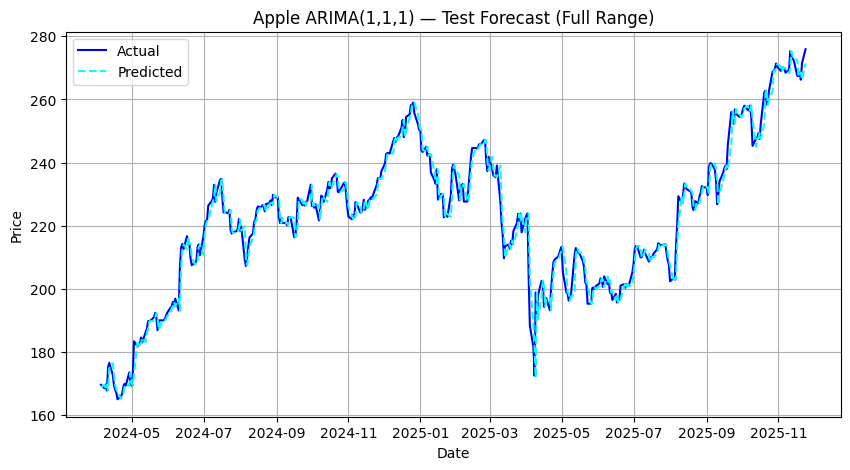

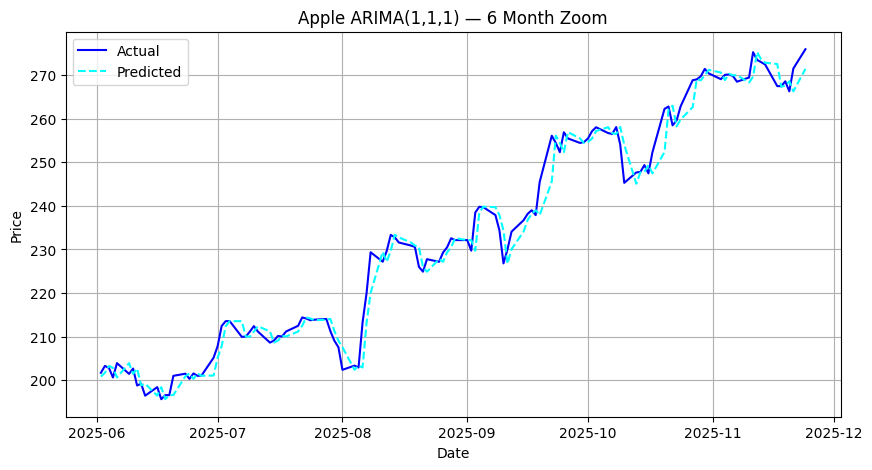

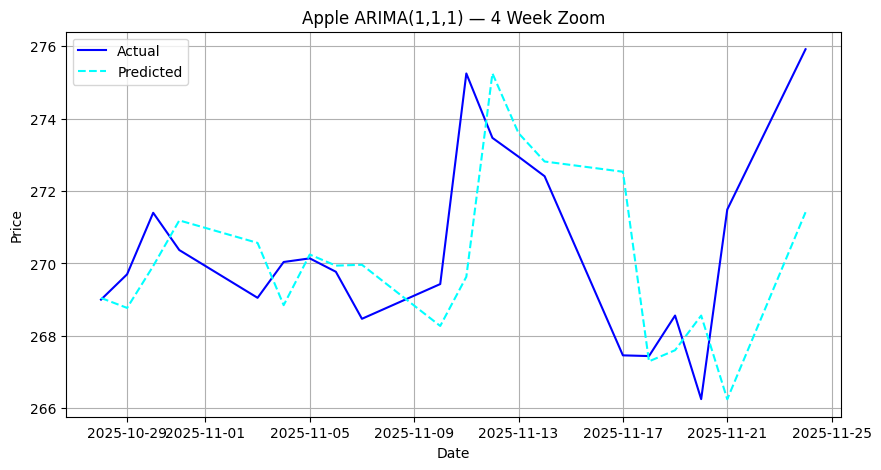

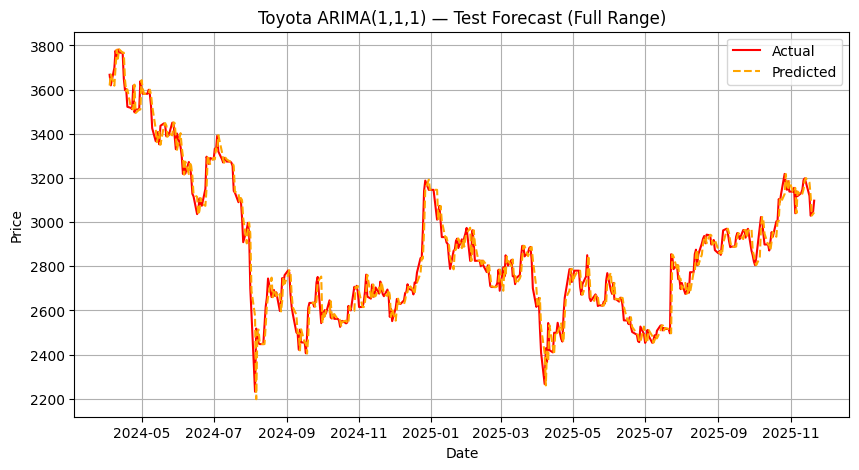

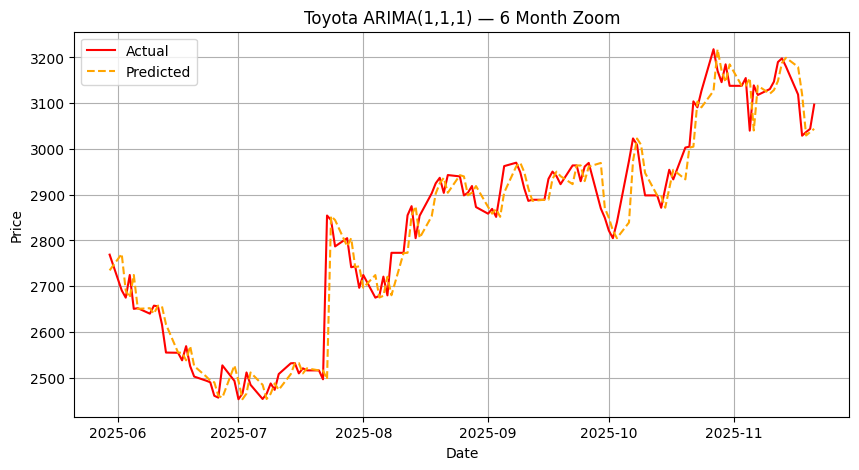

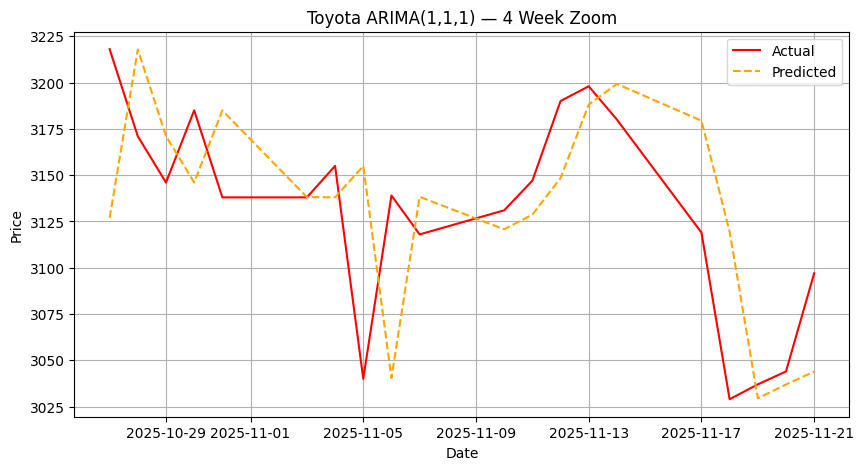

In [29]:
def plot_test_views(actual, predicted, title, actual_color, pred_color):
    actual = pd.Series(np.array(actual).squeeze(), index=actual.index)
    predicted = pd.Series(np.array(predicted).squeeze(), index=predicted.index)

    df = pd.DataFrame({"Actual": actual, "Predicted": predicted})

    # -----------------------------
    # A) Full Test Range
    # -----------------------------
    plt.figure(figsize=(10,5))
    plt.plot(df.index, df["Actual"], label="Actual", color=actual_color)
    plt.plot(df.index, df["Predicted"], label="Predicted", color=pred_color, linestyle="--")
    plt.title(f"{title} — Test Forecast (Full Range)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # -----------------------------
    # B) 6-Month View (~21 days × 6)
    # -----------------------------
    plt.figure(figsize=(10,5))
    zoom_6m = df.iloc[-(6 * 21):]
    plt.plot(zoom_6m.index, zoom_6m["Actual"], label="Actual", color=actual_color)
    plt.plot(zoom_6m.index, zoom_6m["Predicted"], label="Predicted", color=pred_color, linestyle="--")
    plt.title(f"{title} — 6 Month Zoom")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # -----------------------------
    # C) 4-Week View (~5 days × 4)
    # -----------------------------
    plt.figure(figsize=(10,5))
    zoom_4w = df.iloc[-(4 * 5):]
    plt.plot(zoom_4w.index, zoom_4w["Actual"], label="Actual", color=actual_color)
    plt.plot(zoom_4w.index, zoom_4w["Predicted"], label="Predicted", color=pred_color, linestyle="--")
    plt.title(f"{title} — 4 Week Zoom")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_test_views(
    actual=apple_test,
    predicted=pd.Series(apple_test_pred, index=apple_test.index),
    title="Apple ARIMA(1,1,1)",
    actual_color="blue",
    pred_color="cyan"
)
plot_test_views(
    actual=toyota_test,
    predicted=pd.Series(toyota_test_pred, index=toyota_test.index),
    title="Toyota ARIMA(1,1,1)",
    actual_color="red",
    pred_color="orange"
)
